## 교통 신호 분류
LeNet을 통한 분류
43개의 표지판을 분류

In [110]:
# 라이브러리 가져오기
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
# 데이터 불러오기, 데이터 직렬화에 사용
# 파이썬 객체 구조의 직렬화 및 역 직렬화를 위한 이진 프로토콜
# 여기서는 데이터를 여는데만 사용

In [111]:
with open("./traffic-signs-data/train.p", mode='rb') as training_data:
    train = pickle.load(training_data)
with open("./traffic-signs-data/valid.p", mode='rb') as validation_data:
    valid = pickle.load(validation_data)  # 과적합 방지 데이터 셋 
with open("./traffic-signs-data/test.p", mode='rb') as testing_data:
    test = pickle.load(testing_data)

# 피클 모듈을 이용해서 직렬화된 데이터를 불러오는 과정
# 피클은 파이썬 객체 구조를 바이트 스트림으로 변환하는 과정(직렬화)를 통해
# 파일을 저장하거나 네트워크를 통해 전송할 수 있게 해주는 모듈임.

# with open("./traffic-signs-data/train.p", mode='rb') as training_data
# train.p 파일을 바이너리 읽기모드(rb)로 열음. 
# with 문을 사용하면 파일 사용 후 자동으로 닫아주므로 자원관리에 효율적임
# training_data는 열린 파일에 대한 파일 객체를 참조
# train = pickle.load(training_data) : pickle.load로 객체로부터 데이터를 읽고
# 파이썬 객체로 역직렬화를 함

In [112]:
(X_train, y_train) = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [113]:
X_train.shape
# 32 x 32 에 rgb 사진이 34799 장

(34799, 32, 32, 3)

In [114]:
y_train.shape

(34799,)

In [115]:
X_validation.shape

(4410, 32, 32, 3)

In [116]:
X_test.shape

(12630, 32, 32, 3)

## 데이터 보기

23

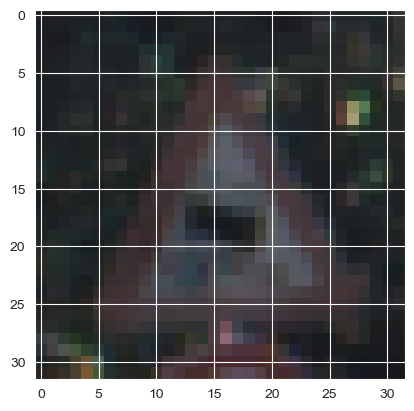

In [117]:
i = 2000
plt.imshow(X_train[i])
y_train[i]

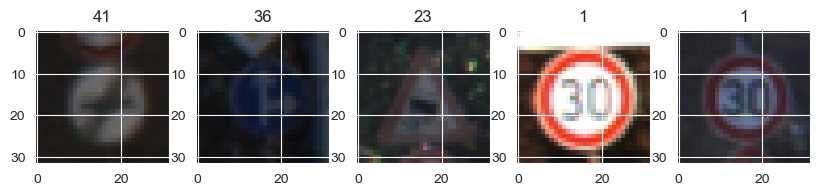

In [118]:
f, ax = plt.subplots(1, 5, figsize=(10, 10))
for i in range(0, 5):
    ax[i].imshow(X_train[i * 1000])
    ax[i].set_title(y_train[i * 1000])

## 데이터 일반화
데이터 흑백으로 => 3개 채널 대신 1채널 사용시 속도 빨라짐
데이터 정규화 0 ~ 255 => 0 ~ 1로 
데이터 셔플, 기존에는 같은 종류끼리 정렬되어있음

In [119]:
# 데이터 셔플
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [120]:
# 데이터를 컬러에서 흑백으로 변경
# RGB 채널을 합친후 3으로 나눌거임, 즉 평균을 구할거임
X_train_gray = np.sum(X_train / 3, axis=3, keepdims=True)
# axis = 3 => 데이터셋의 3번째 인덱스 차원을 합산하라는거 shape 했을때 4번째꺼
# keepdims => 합산 후에도 원래 배열과 동일한 차원 수를 유지하라는 옵션, 컬러채널의 차원이 그대로 1이라는거
#  즉, 만약 X_train의 원래 모양(shape)이 (샘플 수, 높이, 너비, 컬러 채널)이라면, keepdims=True 옵션을 사용할 때의 결과 모양은 (샘플 수, 높이, 너비, 1)이 됩니다. 반면, keepdims=False를 사용하면 결과 모양은 (샘플 수, 높이, 너비)로 컬러 채널 차원이 완전히 사라집니다.

In [121]:
X_train_gray.shape

(34799, 32, 32, 1)

In [122]:
X_test_gray = np.sum(X_test / 3, axis=3, keepdims=True)
X_validation_gray = np.sum(X_validation / 3, axis=3, keepdims=True)

In [123]:
# 정규화
X_train_gray_norm = (X_train_gray - 128) / 128
X_test_gray_norm = (X_test_gray - 128) / 128
X_validation_gray_norm = (X_validation_gray - 128) / 128

# 이게 정규화인 이유
# 1. 중심이동 : 0 - 255 이므로 정규화하기 위해 128을 빼는 것 
# 2. 스케일링, 128로 나누어 모든 픽셀의 값이 -1에서 1사이로 이동
# 하는 이유 학습 속도 향상, 수치 안정성, 특징 간 균형

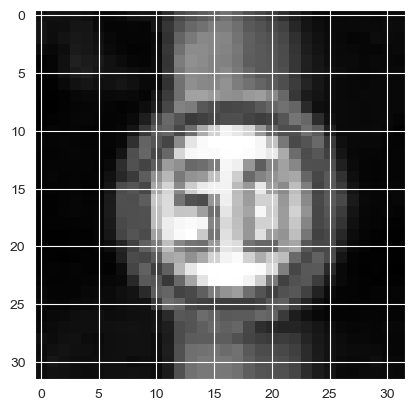

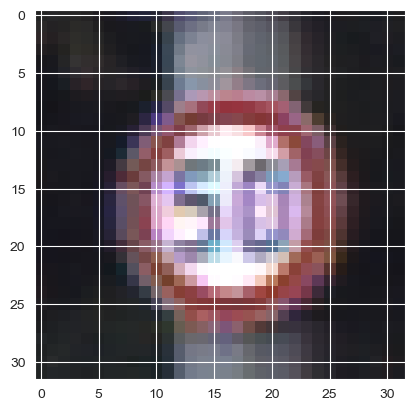

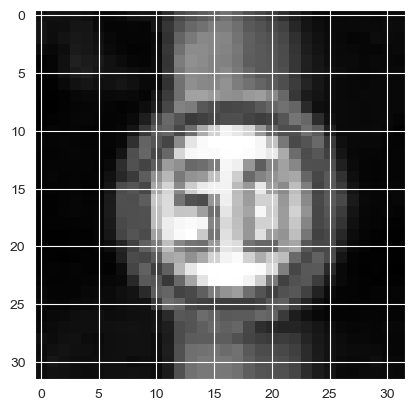

In [124]:
i = 2000
plt.imshow(X_train_gray[i].squeeze(), cmap='gray')  # 흑백
plt.figure()
plt.imshow(X_train[i])  # 원본
plt.figure()
plt.imshow(X_train_gray_norm[i].squeeze(), cmap='gray')  # 흑백 +정규화까지한거

## 모델 훈련


### 1단계: 첫 번째 합성곱 계층 #1
- 입력 크기: 32x32x1
- 출력 크기: 28x28x6
- 계산 과정: (입력 - 필터 + 1) / 스트라이드 => (32 - 5 + 1) / 1 = 28
- 사용된 필터: 5x5 크기의 필터로 입력 깊이는 1, 출력 깊이는 6
- 출력에 RELU 활성화 함수 적용
- 풀링 적용: 입력 28x28x6, 출력 14x14x6
- *스트라이드(stride)는 커널이 이미지를 통과할 때 커널이 이동하는 양을 의미합니다.
### 2단계: 두 번째 합성곱 계층 #2
- 입력 크기: 14x14x6
- 출력 크기: 10x10x16
- 계산 과정: (입력 - 필터 + 1) / 스트라이드 => 10 = (14 - 5 + 1) / 1
- 출력에 RELU 활성화 함수 적용
- 풀링 적용: 입력 10x10x16, 출력 5x5x16
### 3단계: 네트워크 평탄화
- 네트워크를 평탄화하여 입력 크기 5x5x16, 출력 크기 400으로 변경
### 4단계: 전결합 계층
- 3번째 계층: 전결합 계층으로 입력 크기 400, 출력 크기 120
출력에 RELU 활성화 함수 적용
### 5단계: 또 다른 전결합 계층
- 4번째 계층: 전결합 계층으로 입력 크기 120, 출력 크기 84
출력에 RELU 활성화 함수 적용
### 6단계: 전결합 계층
- 5번째 계층: 전결합 계층으로 입력 크기 84, 출력 크기 43

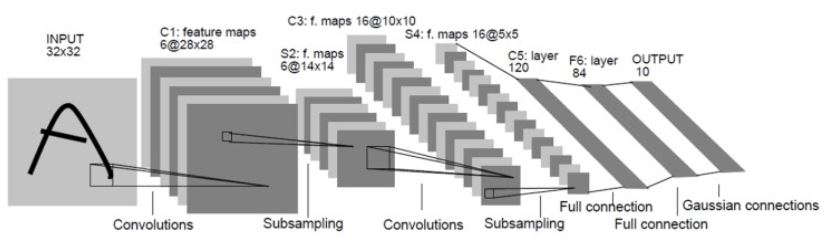

In [125]:
from IPython.display import Image

Image('./img.png', width=500)

In [126]:
# 라이브러리 임포트
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

In [127]:
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(32, 32, 1)))
cnn_model.add(AveragePooling2D())

cnn_model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
cnn_model.add(AveragePooling2D())

cnn_model.add(Flatten())

cnn_model.add(Dense(units=120, activation='relu'))

cnn_model.add(Dense(units=84, activation='relu'))

cnn_model.add(Dense(units=43, activation='softmax'))


In [128]:
cnn_model.compile(
    loss='sparse_categorical_crossentropy',
    # 클래스가 상호배타적일때, 즉 샘플이 정확히 하나의 클래스에 속할때 사용함
    # sparse는 레이블이 정수 형태로 제공될때 사용,
    # 즉 원핫 인코딩 형태가 아닌 0,1,2와 같이 클래스를 직접 나타낼때 사용
    optimizer=Adam(learning_rate=0.001),
    # Adam은 Adaptive Moment Estimation의 약자로, 경사 하강법의 확장
    metrics=['accuracy']
)

In [129]:
history = cnn_model.fit(X_train_gray_norm,
                        y_train,
                        batch_size=500,
                        epochs=5,
                        verbose=1,
                        validation_data=(X_validation_gray_norm, y_validation)
                        )

Epoch 1/5
70/70 [==============================] - 5s 63ms/step - loss: 3.0865 - accuracy: 0.1982 - val_loss: 2.3890 - val_accuracy: 0.3671
Epoch 2/5
70/70 [==============================] - 5s 66ms/step - loss: 1.4999 - accuracy: 0.5756 - val_loss: 1.3437 - val_accuracy: 0.6091
Epoch 3/5
70/70 [==============================] - 4s 60ms/step - loss: 0.8576 - accuracy: 0.7538 - val_loss: 1.0029 - val_accuracy: 0.7041
Epoch 4/5
70/70 [==============================] - 5s 67ms/step - loss: 0.5940 - accuracy: 0.8363 - val_loss: 0.8018 - val_accuracy: 0.7703
Epoch 5/5
70/70 [==============================] - 5s 70ms/step - loss: 0.4686 - accuracy: 0.8750 - val_loss: 0.7370 - val_accuracy: 0.7902


In [130]:
score = cnn_model.evaluate(X_test_gray_norm, y_test)
print('test accuracy : {}'.format(score[1]))

395/395 [==============================] - 2s 6ms/step - loss: 0.9630 - accuracy: 0.7780
test accuracy : 0.7779889106750488


In [131]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [132]:
accuracy = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

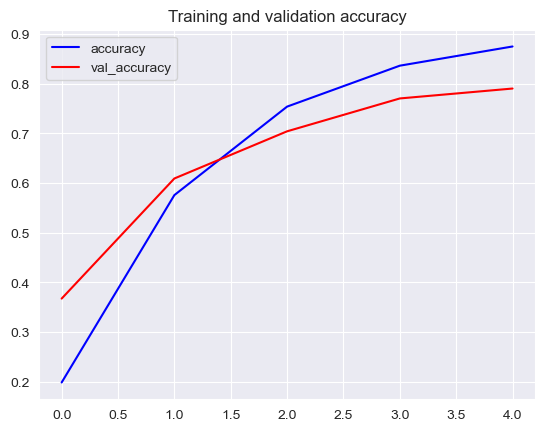

In [133]:
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, color='blue', label='accuracy')
plt.plot(epochs, val_accuracy, color='red', label='val_accuracy')
plt.title('Training and validation accuracy')
plt.legend()

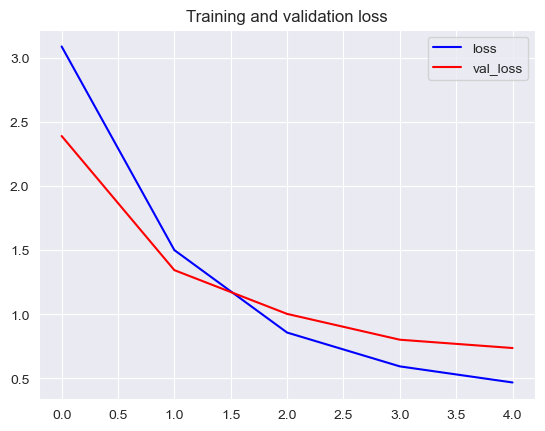

In [134]:
epochs = range(len(accuracy))
plt.plot(epochs, loss, color='blue', label='loss')
plt.plot(epochs, val_loss, color='red', label='val_loss')
plt.title('Training and validation loss')
plt.legend()

In [135]:
# 테스트 셋으로 혼동 행렬 만들기


# 모델을 사용하여 예측을 수행합니다.
predictions = cnn_model.predict(X_test_gray_norm)

# 예측 결과에서 가장 확률이 높은 클래스의 인덱스를 선택합니다.
predicted_classes = np.argmax(predictions, axis=1)

# 실제 레이블을 준비합니다.
y_true = y_test

# 이제 혼동 행렬을 만들 수 있습니다.
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true, predicted_classes)

# 혼동 행렬을 출력합니다.
print(conf_matrix)

395/395 [==============================] - 2s 5ms/step
[[ 11  42   1 ...   0   0   0]
 [  1 592  85 ...   0   0   0]
 [  0  86 554 ...   0   0   0]
 ...
 [  0   0   1 ...  49   0   0]
 [  0   0   0 ...   0  34   1]
 [  0   0   0 ...   0   0  80]]


<Axes: >

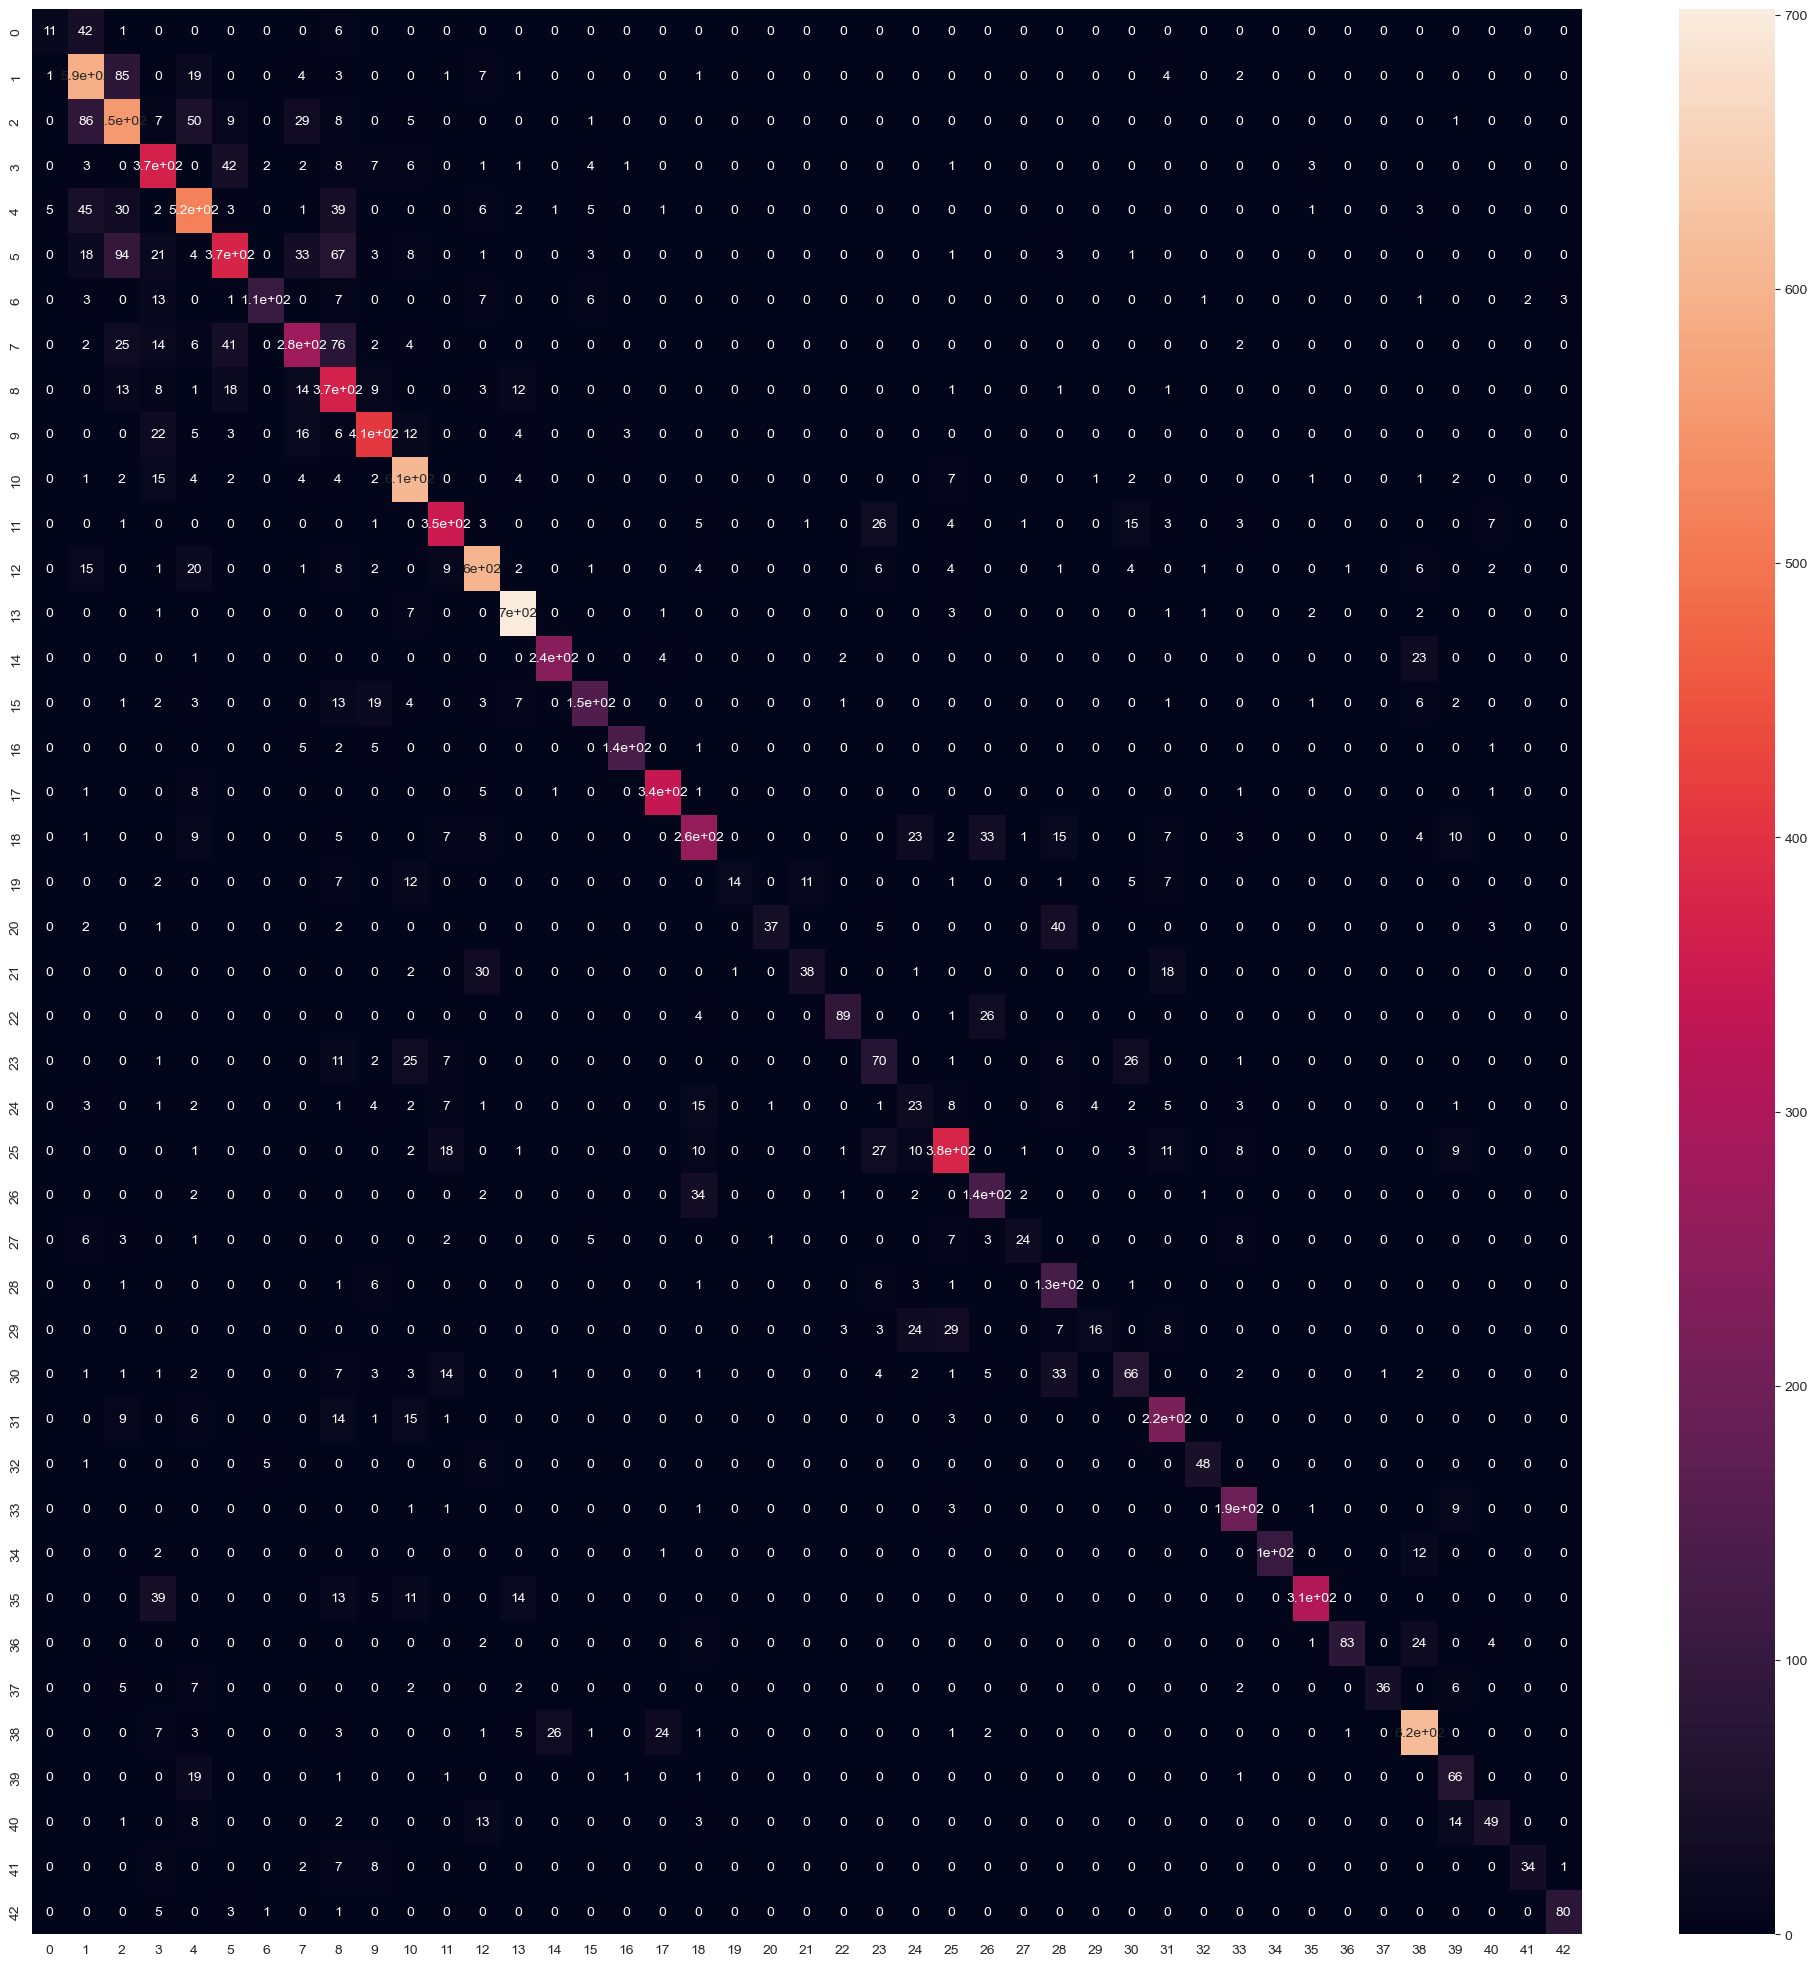

In [136]:
plt.figure(figsize=(25, 25))
sns.heatmap(conf_matrix,annot=True)

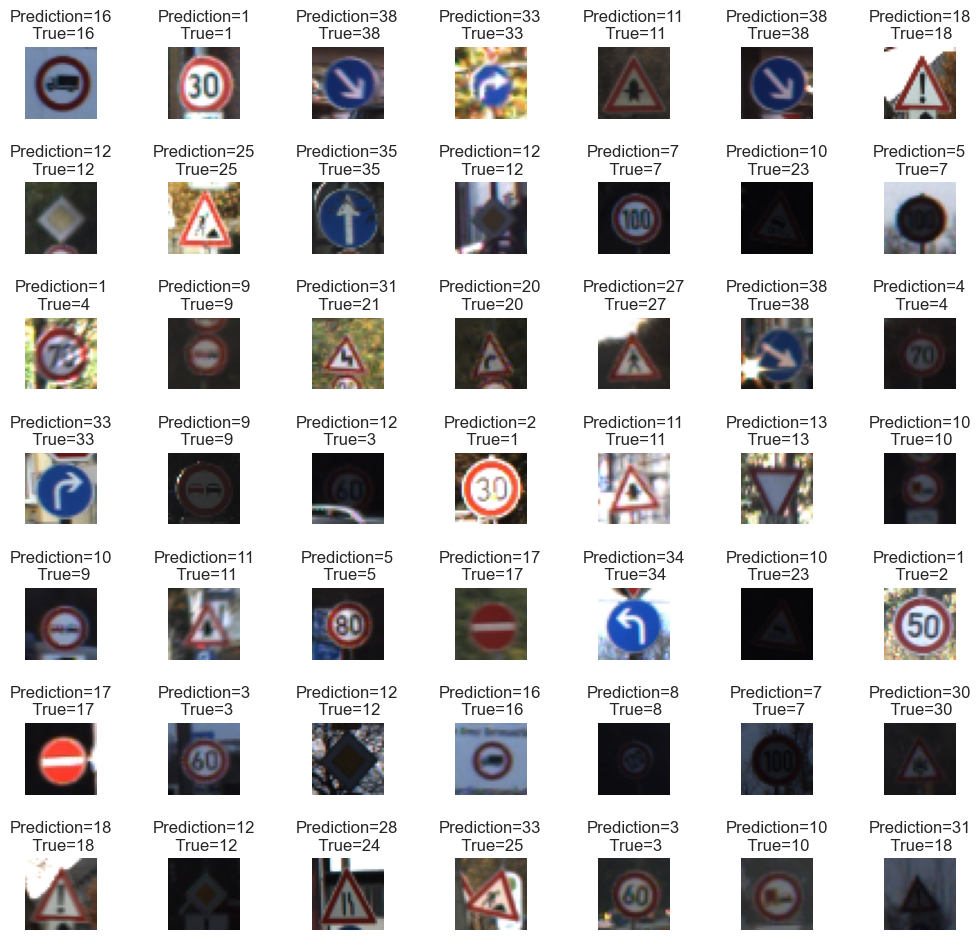

In [137]:
L = 7
W = 7
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel() # axes 배열을 1차원 배열로 변

for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i])
    axes[i].set_title("Prediction={}\n True={}".format(predicted_classes[i], y_true[i]))
    axes[i].axis('off')

plt.subplots_adjust(wspace=1)